<a href="https://www.kaggle.com/code/soggyansh/is-it-hawking?scriptVersionId=129038553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Installing Libraries

In [2]:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2023.1.0 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


## Collecting Image data using DuckDuckGo

Making a function to search images using DuckDuckGo's API

In [14]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"searching for '{term}'")
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [15]:
urls = search_images('eagle bird photos', max_images=1)
urls[0]

searching for 'eagle bird photos'


'https://1.bp.blogspot.com/-tOTA1BN9rXU/WNUHB2m50dI/AAAAAAAAAuU/eFYzvS1wDL0jRb4ek2AnPp8k_NAfUlotACLcB/s1600/Beautiful-Birls-Golden-Eagle-Images-HD-Wallpapers.jpg'

Downloading sample images for both an eagle and a hawk

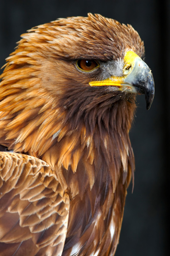

In [16]:
from fastdownload import download_url
dest = 'eagle.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

searching for 'hawk bird photos'


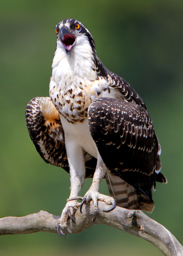

In [17]:
download_url(search_images('hawk bird photos', max_images=1)[0], 'hawk.jpg', show_progress=False)
Image.open('hawk.jpg').to_thumb(256,256)

Downloading all images and creating the dataset

In [18]:
searches = 'eagle','hawk'
path = Path('eagle_or_hawk')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bird photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} bird in sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} bird in shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

searching for 'eagle bird photo'
searching for 'eagle bird in sun photo'
searching for 'eagle bird in shade photo'
searching for 'hawk bird photo'
searching for 'hawk bird in sun photo'
searching for 'hawk bird in shade photo'


In [19]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

removing bad/broken images

## Data Augmentation and Validation Set Split

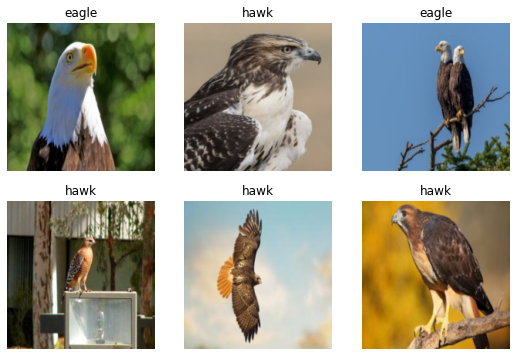

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## ResNet18 Architecture

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.573132,0.170034,0.058309,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.191612,0.145838,0.043732,00:12
1,0.114953,0.126502,0.034985,00:11
2,0.061681,0.102265,0.023324,00:12


As you can see above, the model has an accuracy of 97.7% (accuracy = (1-error_rate)*100)

## Testing the Model

In [24]:
is_eagle,_,probs = learn.predict('hawk.jpg')
print(f"This is: {is_eagle}.")
print(f"Probability it's an eagle: {probs[0]:.8f}")

This is: hawk.
Probability it's an eagle: 0.00000005
